In [1]:
import numpy as np
import pandas as pd
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from keras.layers import Lambda, MaxPool2D, BatchNormalization, MaxPooling2D, Input, Softmax
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import RMSprop
from keras.models import Model
from keras.layers import Input
from keras.utils.vis_utils import plot_model
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import xml.etree.ElementTree as ET
import sklearn
import itertools
import cv2
import scipy
import os
import csv
from tqdm import tqdm
import matplotlib.pyplot as plt
from PIL import Image
%matplotlib inline

Using TensorFlow backend.


In [5]:
print(np.__version__)

1.16.2


In [2]:
dict_characters = {1:'NEUTROPHIL',2:'EOSINOPHIL',3:'MONOCYTE',4:'LYMPHOCYTE'}
dict_characters2 = {0:'Mononuclear',1:'Polynuclear'}

In [7]:
dict_characters

{1: 'NEUTROPHIL', 2: 'EOSINOPHIL', 3: 'MONOCYTE', 4: 'LYMPHOCYTE'}

In [3]:
#Retrieve image information from folders and enforce one-hot-encoding to the labels.
def get_data(folder):
    """
    Load the data and labels from the given folder.
    """
    X = []
    y = []
    z = []
    for wbc_type in os.listdir(folder):
        if not wbc_type.startswith('.'):
            if wbc_type in ['NEUTROPHIL']:
                label = 1
                label2 = 1
            elif wbc_type in ['EOSINOPHIL']:
                label = 2
                label2 = 1
            elif wbc_type in ['MONOCYTE']:
                label = 3  
                label2 = 0
            elif wbc_type in ['LYMPHOCYTE']:
                label = 4 
                label2 = 0
            else:
                label = 5
                label2 = 0
            for image_filename in tqdm(os.listdir(folder + wbc_type)):
                img_file = cv2.imread(folder + wbc_type + '/' + image_filename)
                if img_file is not None:
                    img_file = np.array(Image.fromarray(img_file).resize([80, 60]))
                    #scipy.misc.imresize(arr=img_file, size=(60, 80, 3))
                    img_arr = np.asarray(img_file)
                    X.append(img_arr)
                    y.append(label)
                    z.append(label2)
    X = np.asarray(X)
    y = np.asarray(y)
    z = np.asarray(z)
    return X,y,z
X_train, y_train, z_train = get_data('/scratch/asz241/Blood/dataset2-master/images/TRAIN/')
X_test, y_test, z_test = get_data('/scratch/asz241/Blood/dataset2-master/images/TEST/')
X_test_simple, y_test_simple, z_test_simple = get_data('/scratch/asz241/Blood/dataset2-master/images/TEST_SIMPLE/')
# Encode labels to hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0])
from keras.utils.np_utils import to_categorical
y_trainHot = to_categorical(y_train, num_classes = 5)
y_testHot = to_categorical(y_test, num_classes = 5)
y_stestHot = to_categorical(y_test_simple, num_classes = 5)
z_trainHot = to_categorical(z_train, num_classes = 2)
z_testHot = to_categorical(z_test, num_classes = 2)
z_stestHot = to_categorical(z_test_simple, num_classes = 5)
print(dict_characters)
print(dict_characters2)

100%|██████████| 4/4 [00:00<00:00, 106.15it/s]

{1: 'NEUTROPHIL', 2: 'EOSINOPHIL', 3: 'MONOCYTE', 4: 'LYMPHOCYTE'}
{0: 'Mononuclear', 1: 'Polynuclear'}


In [52]:
y_trainHot.shape

(9957, 5)

In [4]:
#Convert image data into a numpy array and normalize all the values.
X_train=np.array(X_train)
X_train=X_train/255.0

X_test=np.array(X_test)
X_test=X_test/255.0


X_test_simple=np.array(X_test_simple)
X_test_simple=X_test_simple/255.0

x_train1, x_valid, y_train1, y_valid = train_test_split(X_train, y_trainHot, test_size=0.20, shuffle= True)

In [13]:
#Functions to save metrics after every epoch, and functions to plot learning curve, confusion matrix, and provide precision recall information.
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

class MetricsCheckpoint(Callback):
    """Callback that saves metrics after each epoch"""
    def __init__(self, savepath):
        super(MetricsCheckpoint, self).__init__()
        self.savepath = savepath
        self.history = {}
    def on_epoch_end(self, epoch, logs=None):
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        np.save(self.savepath, self.history)

def plotKerasLearningCurve():
    plt.figure(figsize=(10,5))
    metrics = np.load('logs.npy')[()]
    filt = ['acc'] # try to add 'loss' to see the loss learning curve
    for k in filter(lambda x : np.any([kk in x for kk in filt]), metrics.keys()):
        l = np.array(metrics[k])
        plt.plot(l, c= 'r' if 'val' not in k else 'b', label='val' if 'val' in k else 'train')
        x = np.argmin(l) if 'loss' in k else np.argmax(l)
        y = l[x]
        plt.scatter(x,y, lw=0, alpha=0.25, s=100, c='r' if 'val' not in k else 'b')
        plt.text(x, y, '{} = {:.4f}'.format(x,y), size='15', color= 'r' if 'val' not in k else 'b')   
    plt.legend(loc=4)
    plt.axis([0, None, None, None]);
    plt.grid()
    plt.xlabel('Number of epochs')
    plt.ylabel('Accuracy')

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize = (5,5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def plot_learning_curve(history):
    plt.figure(figsize=(8,4))
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('./accuracy_curve.png')
    #plt.clf()
    # summarize history for loss
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('./loss_curve.png')

In [5]:
input_img = Input(shape = (60, 80, 3))

pre = Conv2D(64, (1,1), padding='same', activation='relu')(input_img)
pre = Conv2D(64, (3,3), padding='same', activation='relu')(pre)
pre = MaxPooling2D(pool_size=(2,2), strides=(1,1), padding='same')(pre)

tower_1 = Conv2D(64, (1,1), padding='same', activation='relu')(pre)
tower_1 = Conv2D(64, (3,3), padding='same', activation='relu')(tower_1)

tower_2 = Conv2D(64, (1,1), padding='same', activation='relu')(pre)
tower_2 = Conv2D(64, (3,3), padding='same', activation='relu')(tower_2)
tower_2 = Conv2D(64, (3,3), padding='same', activation='relu')(tower_2)

tower_3 = MaxPooling2D((3,3), strides=(1,1), padding='same')(pre)
tower_3 = Conv2D(64, (1,1), padding='same', activation='relu')(tower_3)
output1 = keras.layers.concatenate([tower_1, tower_2, tower_3], axis = 3)

output1 = Flatten()(output1)
#d1 = Dense(1200, activation ='relu')(output1)
#d1 = Dropout(0.3)(d1)
#d2 = Dense(600, activation ='relu')(d1)
#d3 = Dense(120, activation ='relu')(output1)
out1 = Dense(5, activation='softmax')(output1)

In [38]:
#conda install graphviz

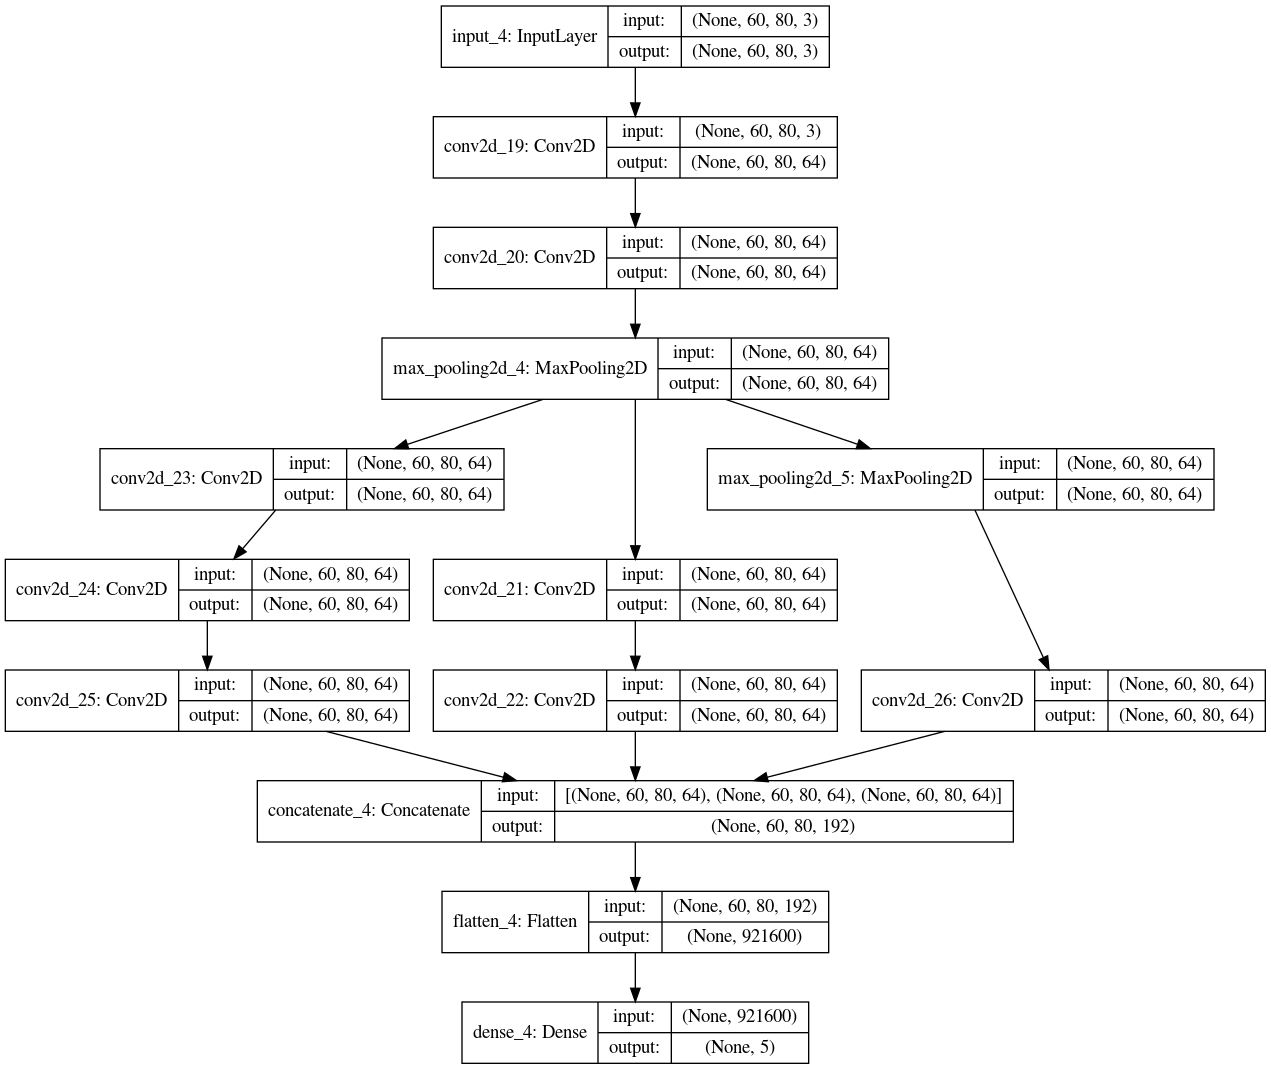

In [39]:
mod1 = Model(inputs = input_img, outputs = out1)
plot_model(mod1, to_file='mod1.png', show_shapes=True, show_layer_names=True)


In [40]:
mod1.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adadelta(),
                  metrics=['accuracy'])

datagen = ImageDataGenerator(
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
    rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=True,  # randomly flip images
    vertical_flip=False)  # randomly flip images

his1 = mod1.fit_generator(datagen.flow(x_train1, y_train1, batch_size=32),
                        steps_per_epoch=len(x_train1)/32, epochs=15, validation_data = (x_valid, y_valid), callbacks = [MetricsCheckpoint('logs'), checkpoint])

Epoch 1/15
249/248 [==============================] - 206s 825ms/step - loss: 1.5817 - accuracy: 0.2859 - val_loss: 1.3380 - val_accuracy: 0.3399

Epoch 00001: val_loss improved from 1.21026 to 1.33803, saving model to mod2.h5
Epoch 2/15
249/248 [==============================] - 218s 875ms/step - loss: 1.2324 - accuracy: 0.4419 - val_loss: 0.9619 - val_accuracy: 0.5949

Epoch 00002: val_loss did not improve from 1.33803
Epoch 3/15
249/248 [==============================] - 204s 818ms/step - loss: 0.9218 - accuracy: 0.6060 - val_loss: 0.6394 - val_accuracy: 0.7520

Epoch 00003: val_loss did not improve from 1.33803
Epoch 4/15
249/248 [==============================] - 203s 817ms/step - loss: 0.6777 - accuracy: 0.7259 - val_loss: 0.7564 - val_accuracy: 0.6767

Epoch 00004: val_loss did not improve from 1.33803
Epoch 5/15
249/248 [==============================] - 197s 793ms/step - loss: 0.7115 - accuracy: 0.7476 - val_loss: 0.4566 - val_accuracy: 0.8122

Epoch 00005: val_loss did not im

In [6]:
input_img = Input(shape = (60, 80, 3))

tower_1 = Conv2D(64, (1,1), padding='same', activation='relu')(input_img)

tower_2 = Conv2D(64, (1,1), padding='same', activation='relu')(input_img)
tower_2a = Conv2D(64, (1,3), padding='same', activation='relu')(tower_2)
tower_2b = Conv2D(64, (3,1), padding='same', activation='relu')(tower_2)


tower_3 = Conv2D(64, (1,1), padding='same', activation='relu')(input_img)
tower_3 = Conv2D(64, (1,3), padding='same', activation='relu')(tower_3)
tower_3 = Conv2D(64, (3,1), padding='same', activation='relu')(tower_3)
tower_3a = Conv2D(64, (1,3), padding='same', activation='relu')(tower_3)
tower_3b = Conv2D(64, (3,1), padding='same', activation='relu')(tower_3)

tower_4 = Conv2D(64, (1,1), padding='same', activation='relu')(input_img)
tower_4 = Conv2D(64, (1,3), padding='same', activation='relu')(tower_4)
tower_4 = Conv2D(64, (3,1), padding='same', activation='relu')(tower_4)
tower_4 = Conv2D(64, (1,3), padding='same', activation='relu')(tower_4)
tower_4 = Conv2D(64, (3,1), padding='same', activation='relu')(tower_4)
tower_4a = Conv2D(64, (1,3), padding='same', activation='relu')(tower_4)
tower_4b = Conv2D(64, (3,1), padding='same', activation='relu')(tower_4)


tower_5 = MaxPooling2D((3,3), strides=(1,1), padding='same')(input_img)
tower_5 = Conv2D(64, (1,1), padding='same', activation='relu')(tower_5)

output = keras.layers.concatenate([tower_1, tower_2a, tower_2b, tower_3a, tower_3b, tower_4a, tower_4b, tower_5], axis = 3)
output = Flatten()(output)
out = Dense(5, activation='softmax')(output)

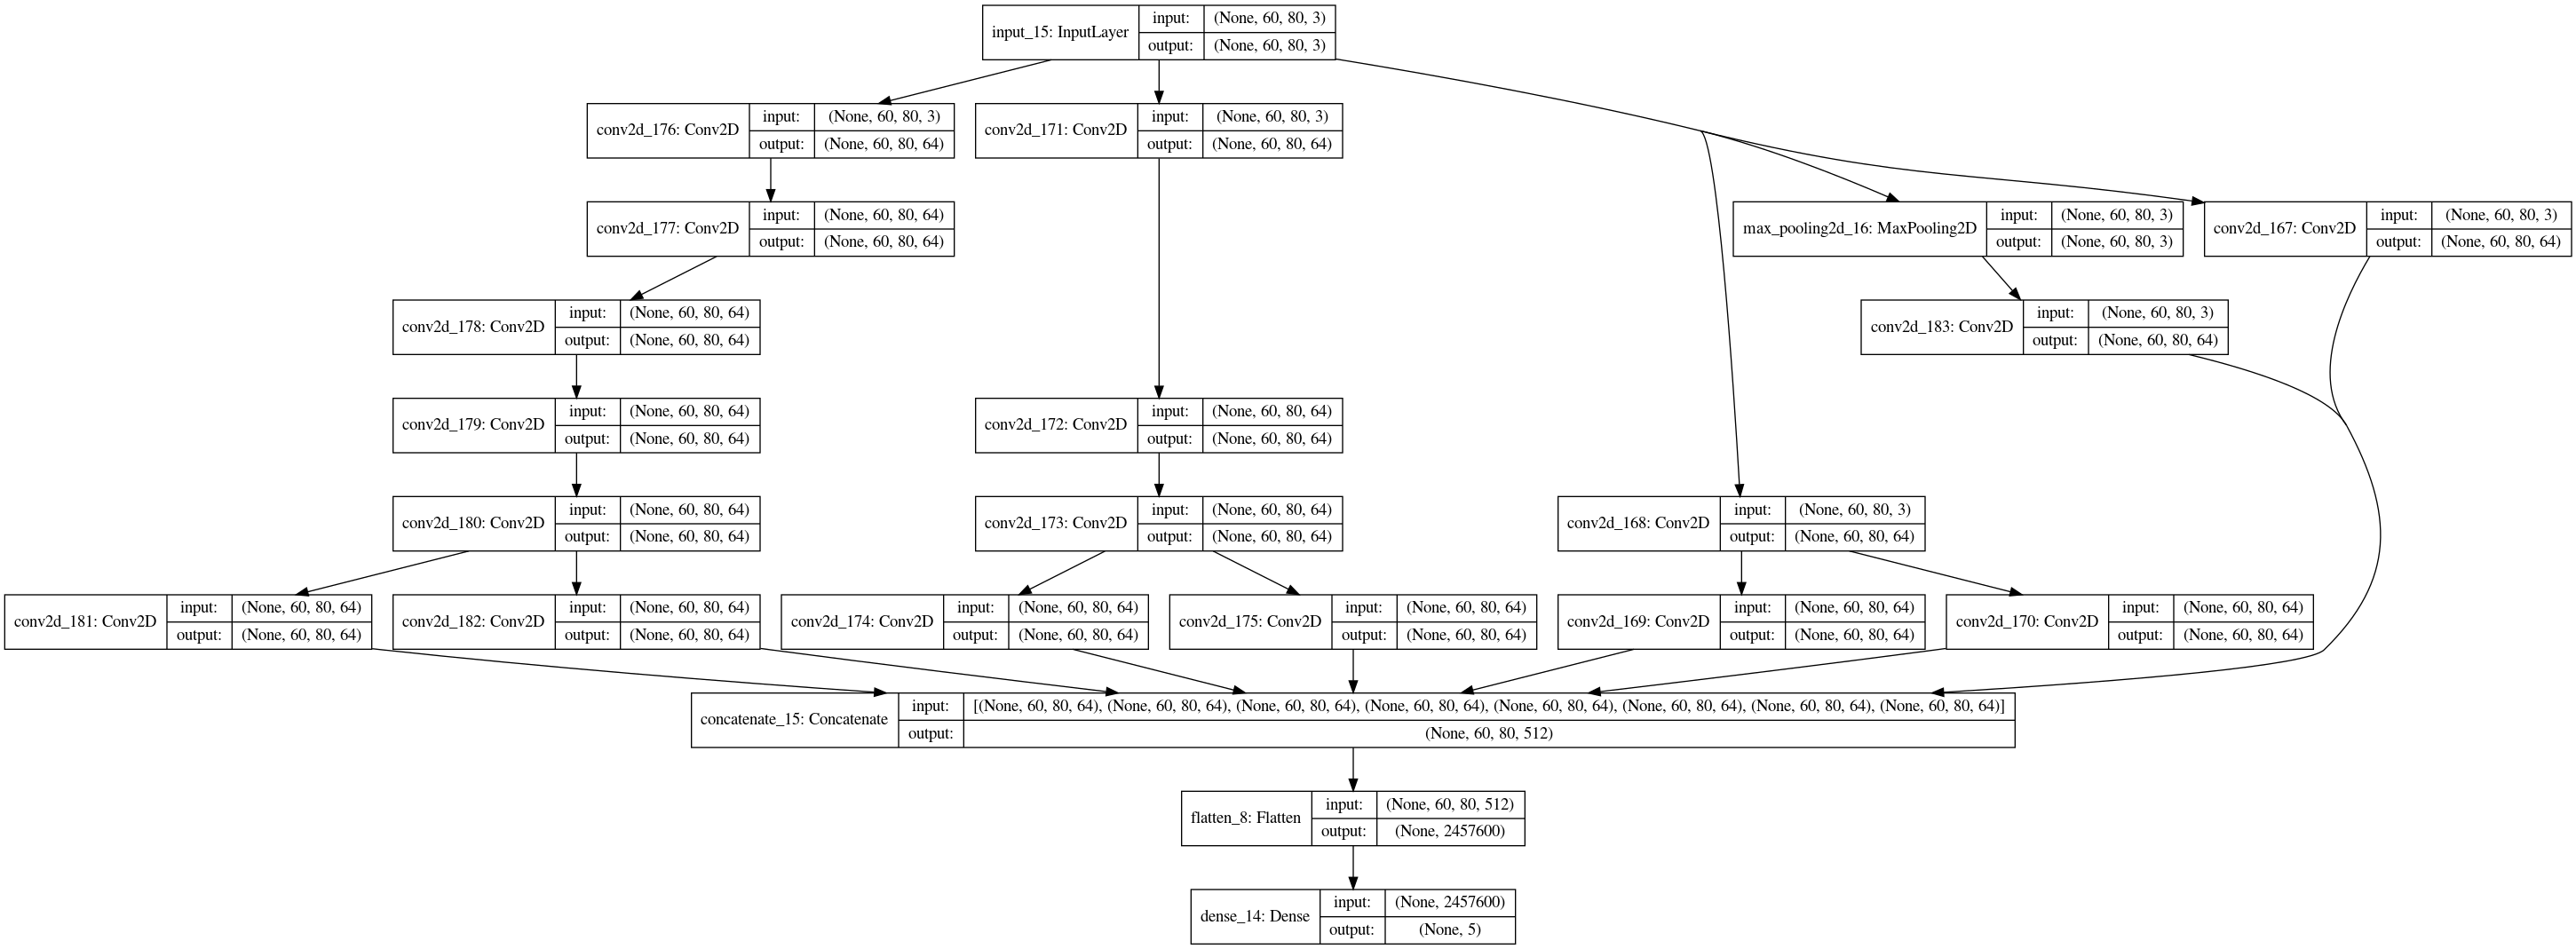

In [73]:
mod2 = Model(inputs = input_img, outputs = out)
plot_model(mod2, to_file='model.png', show_shapes=True, show_layer_names=True)


In [75]:
checkpoint = ModelCheckpoint(filepath='mod2.h5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
mod2.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adadelta(),
                  metrics=['accuracy'])

datagen = ImageDataGenerator(
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
    rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=True,  # randomly flip images
    vertical_flip=False)  # randomly flip images

his2 = mod2.fit_generator(datagen.flow(x_train1, y_train1, batch_size=32),
                        steps_per_epoch=len(x_train1)/32, epochs=15, validation_data = (x_valid, y_valid), callbacks = [MetricsCheckpoint('logs'), checkpoint])

Epoch 1/15
249/248 [==============================] - 288s 1s/step - loss: 1.1935 - accuracy: 0.4817 - val_loss: 1.0753 - val_accuracy: 0.5261

Epoch 00001: val_accuracy improved from -inf to 0.52610, saving model to mod2.h5
Epoch 2/15
249/248 [==============================] - 311s 1s/step - loss: 1.0128 - accuracy: 0.5755 - val_loss: 0.8842 - val_accuracy: 0.6621

Epoch 00002: val_accuracy improved from 0.52610 to 0.66215, saving model to mod2.h5
Epoch 3/15
249/248 [==============================] - 305s 1s/step - loss: 0.9237 - accuracy: 0.6090 - val_loss: 0.7736 - val_accuracy: 0.6867

Epoch 00003: val_accuracy improved from 0.66215 to 0.68675, saving model to mod2.h5
Epoch 4/15
249/248 [==============================] - 307s 1s/step - loss: 0.8564 - accuracy: 0.6481 - val_loss: 0.7250 - val_accuracy: 0.7038

Epoch 00004: val_accuracy improved from 0.68675 to 0.70382, saving model to mod2.h5
Epoch 5/15
249/248 [==============================] - 302s 1s/step - loss: 0.7964 - accurac

In [23]:
mod2.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adadelta(),
                  metrics=['accuracy'])

datagen = ImageDataGenerator(
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
    rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=True,  # randomly flip images
    vertical_flip=False)  # randomly flip images

his2 = mod2.fit_generator(datagen.flow(x_train1, y_train1, batch_size=32),
                        steps_per_epoch=len(x_train1)/32, epochs=25, validation_data = (x_valid, y_valid), callbacks = [MetricsCheckpoint('logs'), checkpoint])

Epoch 1/25
249/248 [==============================] - 311s 1s/step - loss: 3.4537 - accuracy: 0.3492 - val_loss: 1.1962 - val_accuracy: 0.4849
Epoch 2/25


/home/asz241/env/dl4med/lib/python3.7/site-packages/keras/callbacks/callbacks.py:707: RuntimeWarning: Can save best model only with val_acc available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


249/248 [==============================] - 307s 1s/step - loss: 1.1338 - accuracy: 0.4973 - val_loss: 1.1591 - val_accuracy: 0.4503
Epoch 3/25
249/248 [==============================] - 303s 1s/step - loss: 1.0203 - accuracy: 0.5610 - val_loss: 1.0455 - val_accuracy: 0.5126
Epoch 4/25
249/248 [==============================] - 327s 1s/step - loss: 0.9558 - accuracy: 0.5893 - val_loss: 0.8303 - val_accuracy: 0.6707
Epoch 5/25
249/248 [==============================] - 291s 1s/step - loss: 0.9116 - accuracy: 0.6127 - val_loss: 0.8447 - val_accuracy: 0.6551
Epoch 6/25
249/248 [==============================] - 293s 1s/step - loss: 0.8595 - accuracy: 0.6389 - val_loss: 0.7995 - val_accuracy: 0.6923
Epoch 7/25
249/248 [==============================] - 293s 1s/step - loss: 0.8205 - accuracy: 0.6561 - val_loss: 0.7294 - val_accuracy: 0.7058
Epoch 8/25
249/248 [==============================] - 302s 1s/step - loss: 0.8165 - accuracy: 0.6569 - val_loss: 0.7342 - val_accuracy: 0.6938
Epoch 9/25

In [ ]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate = 0.0005),  # Optimizer
              # Loss function to minimize
              loss=keras.losses.CategoricalCrossentropy(from_logits=True),
              # List of metrics to monitor
              metrics=['accuracy'])

datagen = ImageDataGenerator(
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
    rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=True,  # randomly flip images
    vertical_flip=False)  # randomly flip images

history = model.fit_generator(datagen.flow(a,b, batch_size=32),
                        steps_per_epoch=len(a) / 32, epochs=epochs, validation_data = [c, d],callbacks = [MetricsCheckpoint('logs')])

In [9]:

input_img = Input(shape = (60, 80, 3))

pre = Conv2D(64, (1,1), padding='same', activation='relu')(input_img)
pre = Conv2D(64, (3,3), padding='same', activation='relu')(pre)
#pre = MaxPooling2D(pool_size=(2,2), strides=(1,1), padding='same')(pre)

tower_1 = Conv2D(64, (1,1), padding='same', activation='relu')(pre)
tower_1 = Conv2D(64, (3,3), padding='same', activation='relu')(tower_1)

tower_2 = Conv2D(64, (1,1), padding='same', activation='relu')(pre)
tower_2 = Conv2D(64, (3,3), padding='same', activation='relu')(tower_2)
tower_2 = Conv2D(64, (3,3), padding='same', activation='relu')(tower_2)

tower_3 = MaxPooling2D((3,3), strides=(1,1), padding='same')(pre)
tower_3 = Conv2D(64, (1,1), padding='same', activation='relu')(tower_3)
output1 = keras.layers.concatenate([tower_1, tower_2, tower_3], axis = 3)

output1 = Flatten()(output1)
#output1 = Dropout(0.2)(output1)
out1 = Dense(5, activation='softmax')(output1)

In [11]:
mod3 = Model(inputs = input_img, outputs = out1)
mod3.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 60, 80, 3)    0                                            
__________________________________________________________________________________________________
conv2d_34 (Conv2D)              (None, 60, 80, 64)   256         input_4[0][0]                    
__________________________________________________________________________________________________
conv2d_35 (Conv2D)              (None, 60, 80, 64)   36928       conv2d_34[0][0]                  
__________________________________________________________________________________________________
conv2d_38 (Conv2D)              (None, 60, 80, 64)   4160        conv2d_35[0][0]                  
____________________________________________________________________________________________

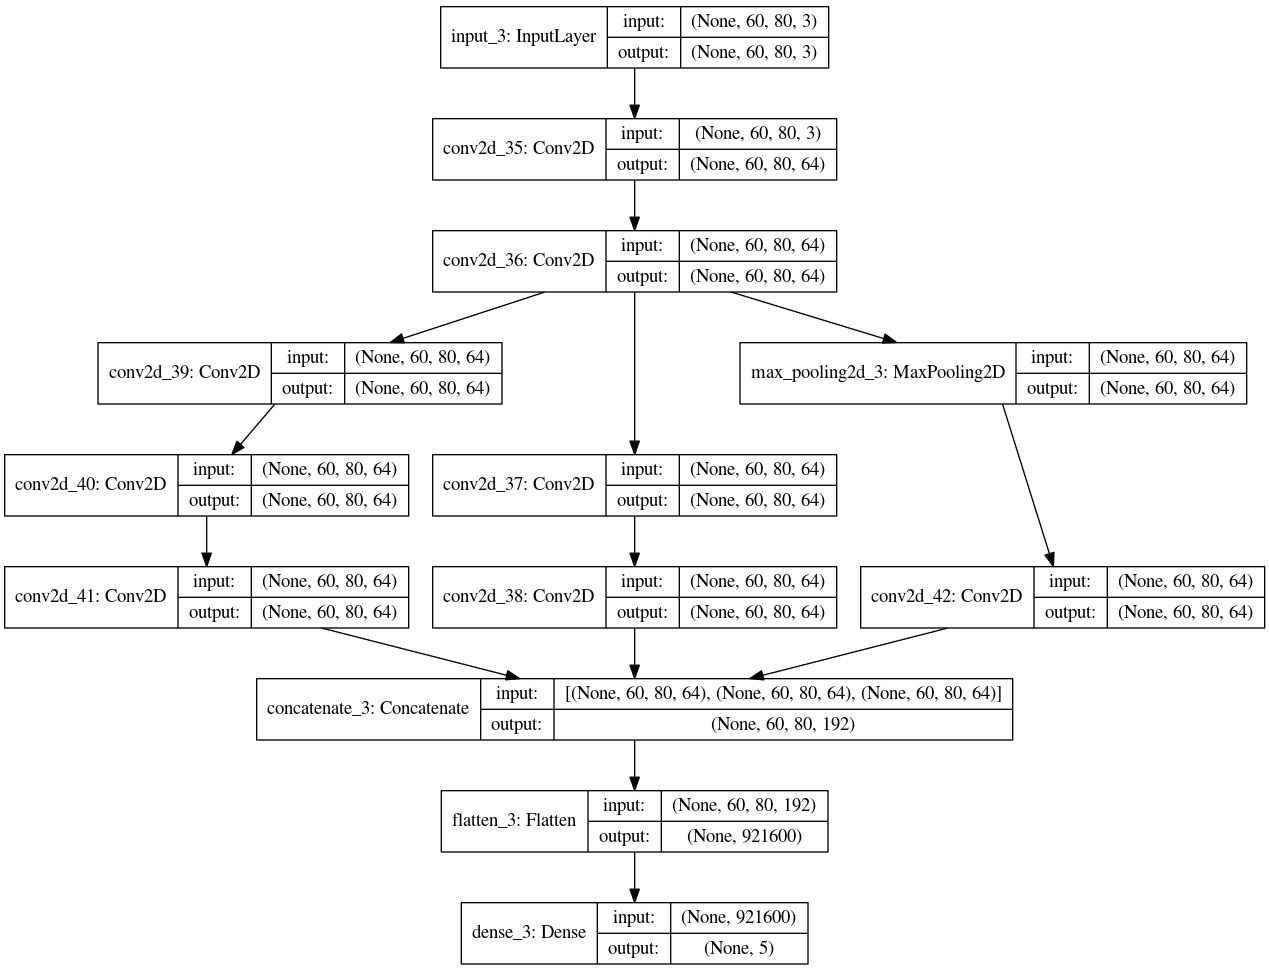

In [29]:
plot_model(mod3, to_file='mod3.png', show_shapes=True, show_layer_names=True)


In [ ]:
checkpoint = ModelCheckpoint(filepath='mod3a.h5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
mod3.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adadelta(),
                  metrics=['accuracy'])

datagen = ImageDataGenerator(
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
    rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=True,  # randomly flip images
    vertical_flip=False)  # randomly flip images

his3 = mod3.fit_generator(datagen.flow(x_train1, y_train1, batch_size=32),
                        steps_per_epoch=len(x_train1)/32, epochs=15, validation_data = (x_valid, y_valid), callbacks = [MetricsCheckpoint('logs'), checkpoint])

Epoch 1/15
249/248 [==============================] - 710s 3s/step - loss: 1.6039 - accuracy: 0.2962 - val_loss: 1.4845 - val_accuracy: 0.2992

Epoch 00001: val_accuracy improved from -inf to 0.29920, saving model to mod3a.h5
Epoch 2/15
249/248 [==============================] - 704s 3s/step - loss: 1.2563 - accuracy: 0.4225 - val_loss: 1.0908 - val_accuracy: 0.5377

Epoch 00002: val_accuracy improved from 0.29920 to 0.53765, saving model to mod3a.h5
Epoch 3/15
249/248 [==============================] - 705s 3s/step - loss: 1.0155 - accuracy: 0.5540 - val_loss: 0.8834 - val_accuracy: 0.6130

Epoch 00003: val_accuracy improved from 0.53765 to 0.61295, saving model to mod3a.h5
Epoch 4/15
249/248 [==============================] - 705s 3s/step - loss: 0.7305 - accuracy: 0.6965 - val_loss: 0.5357 - val_accuracy: 0.7550

Epoch 00004: val_accuracy improved from 0.61295 to 0.75502, saving model to mod3a.h5
Epoch 5/15
249/248 [==============================] - 744s 3s/step - loss: 0.5533 - acc

In [30]:

input_shape = (60, 80, 3)
mod4 = Sequential()
mod4.add(Conv2D(32, kernel_size=(1, 1),
                     activation='relu',
                     input_shape=input_shape,strides=1))
mod4.add(Conv2D(64, (3, 3), activation='relu'))
mod4.add(Conv2D(64, (3, 3), activation='relu'))
mod4.add(Conv2D(64, (3, 3), activation='relu'))
mod4.add(MaxPooling2D(pool_size=(2, 2)))
mod4.add(Dropout(0.25))
mod4.add(Flatten())
mod4.add(Dense(128, activation='relu'))
mod4.add(Dropout(0.5))
mod4.add(Dense(5, activation='softmax'))

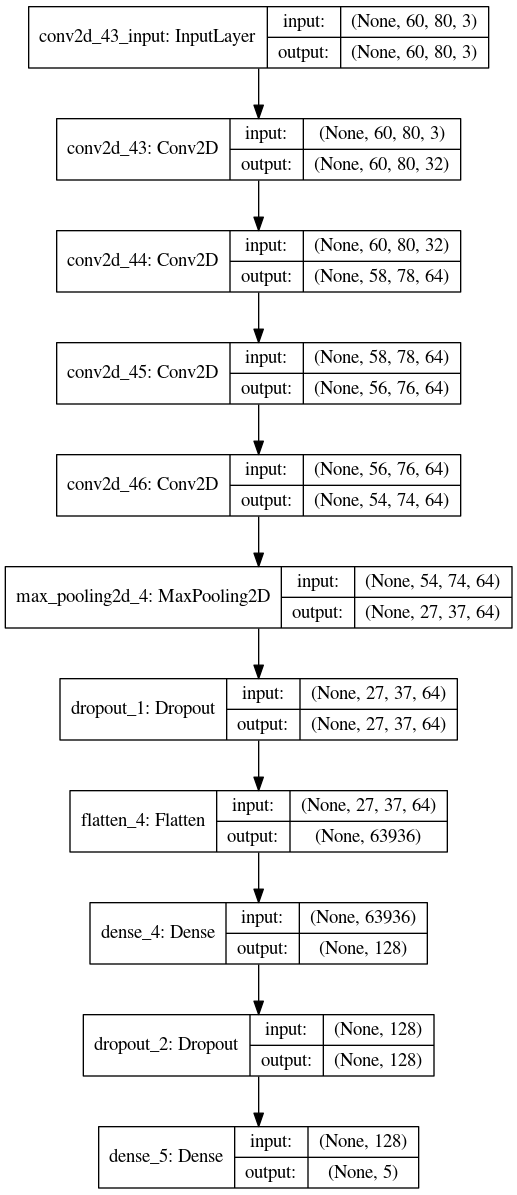

In [31]:
plot_model(mod4, to_file='mod4.png', show_shapes=True, show_layer_names=True)


In [53]:
epochs=15
mod4.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adadelta(),
                  metrics=['accuracy'])

datagen = ImageDataGenerator(
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
    rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=True,  # randomly flip images
    vertical_flip=False)  # randomly flip images

his4 = mod4.fit_generator(datagen.flow(x_train1, y_train1, batch_size=32),
                        steps_per_epoch=len(x_train1)/32, epochs=15, validation_data = (x_valid, y_valid), callbacks = [MetricsCheckpoint('logs')])

Epoch 1/15
249/248 [==============================] - 119s 476ms/step - loss: 1.4259 - accuracy: 0.2624 - val_loss: 1.3248 - val_accuracy: 0.4222
Epoch 2/15
249/248 [==============================] - 117s 468ms/step - loss: 1.3188 - accuracy: 0.3662 - val_loss: 1.1884 - val_accuracy: 0.5141
Epoch 3/15
249/248 [==============================] - 128s 515ms/step - loss: 1.1841 - accuracy: 0.4578 - val_loss: 1.3254 - val_accuracy: 0.3830
Epoch 4/15
249/248 [==============================] - 121s 486ms/step - loss: 1.0655 - accuracy: 0.5235 - val_loss: 0.9521 - val_accuracy: 0.5919
Epoch 5/15
249/248 [==============================] - 119s 479ms/step - loss: 0.9018 - accuracy: 0.6067 - val_loss: 0.6793 - val_accuracy: 0.6792
Epoch 6/15
249/248 [==============================] - 130s 521ms/step - loss: 0.6904 - accuracy: 0.6810 - val_loss: 0.5050 - val_accuracy: 0.7856
Epoch 7/15
249/248 [==============================] - 121s 488ms/step - loss: 0.5307 - accuracy: 0.7596 - val_loss: 0.2947 -

In [32]:

input_shape = (60, 80, 3)
mod5= Sequential()
mod5.add(Conv2D(32, kernel_size=(1, 1),
                     activation='relu',
                     input_shape=input_shape,strides=1))
mod5.add(Conv2D(64, (3, 3), activation='relu'))
mod5.add(MaxPooling2D(pool_size=(2, 2)))
mod5.add(Dropout(0.25))
mod5.add(Flatten())
mod5.add(Dense(128, activation='relu'))
mod5.add(Dropout(0.5))
mod5.add(Dense(5, activation='softmax'))

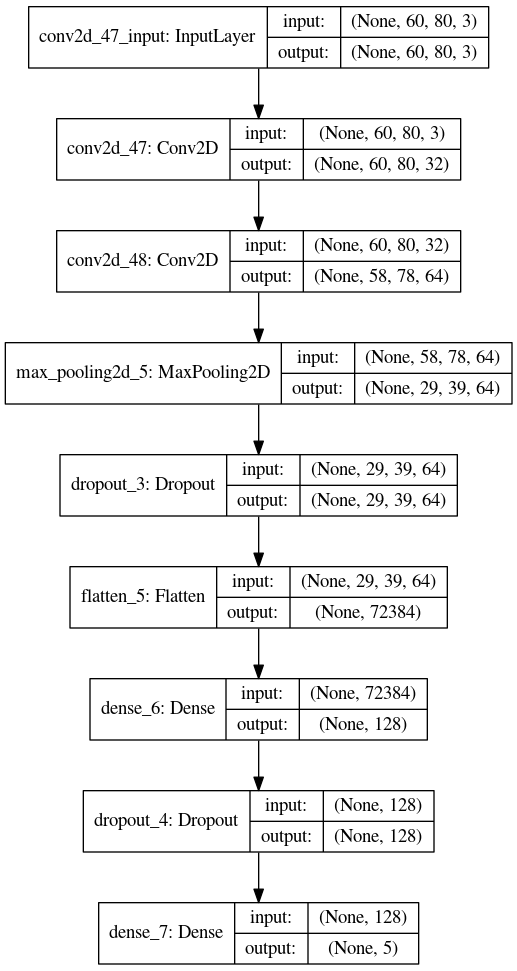

In [33]:
plot_model(mod5, to_file='mod5.png', show_shapes=True, show_layer_names=True)


In [25]:
epochs=30
mod5.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adadelta(),
                  metrics=['accuracy'])

datagen = ImageDataGenerator(
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
    rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=True,  # randomly flip images
    vertical_flip=False)  # randomly flip images

his5 = mod5.fit_generator(datagen.flow(x_train1, y_train1, batch_size=32),
                        steps_per_epoch=len(x_train1)/32, epochs=25, validation_data = (x_valid, y_valid), callbacks = [MetricsCheckpoint('logs')])

Epoch 1/25
249/248 [==============================] - 155s 623ms/step - loss: 1.4424 - accuracy: 0.2549 - val_loss: 1.3866 - val_accuracy: 0.2520
Epoch 2/25
249/248 [==============================] - 149s 597ms/step - loss: 1.3971 - accuracy: 0.2541 - val_loss: 1.3844 - val_accuracy: 0.2877
Epoch 3/25
249/248 [==============================] - 148s 596ms/step - loss: 1.3820 - accuracy: 0.2804 - val_loss: 1.3285 - val_accuracy: 0.3504
Epoch 4/25
249/248 [==============================] - 158s 636ms/step - loss: 1.3393 - accuracy: 0.3406 - val_loss: 1.2790 - val_accuracy: 0.3785
Epoch 5/25
249/248 [==============================] - 158s 634ms/step - loss: 1.2964 - accuracy: 0.3710 - val_loss: 1.2237 - val_accuracy: 0.4287
Epoch 6/25
249/248 [==============================] - 155s 621ms/step - loss: 1.2526 - accuracy: 0.4024 - val_loss: 1.1773 - val_accuracy: 0.4518
Epoch 7/25
249/248 [==============================] - 149s 600ms/step - loss: 1.1974 - accuracy: 0.4354 - val_loss: 1.0884 -

In [34]:
input_shape = (60, 80, 3)
mod6= Sequential()
mod6.add(Conv2D(32, kernel_size=(1, 1),
                     activation='relu',
                     input_shape=input_shape,strides=1))
mod6.add(Conv2D(64, (3, 3), activation='relu'))
mod6.add(Conv2D(64, (3, 3), activation='relu'))
mod6.add(MaxPooling2D(pool_size=(2, 2)))
mod6.add(Dropout(0.25))
mod6.add(Flatten())
mod6.add(Dense(128, activation='relu'))
mod6.add(Dropout(0.5))
mod6.add(Dense(5, activation='softmax'))

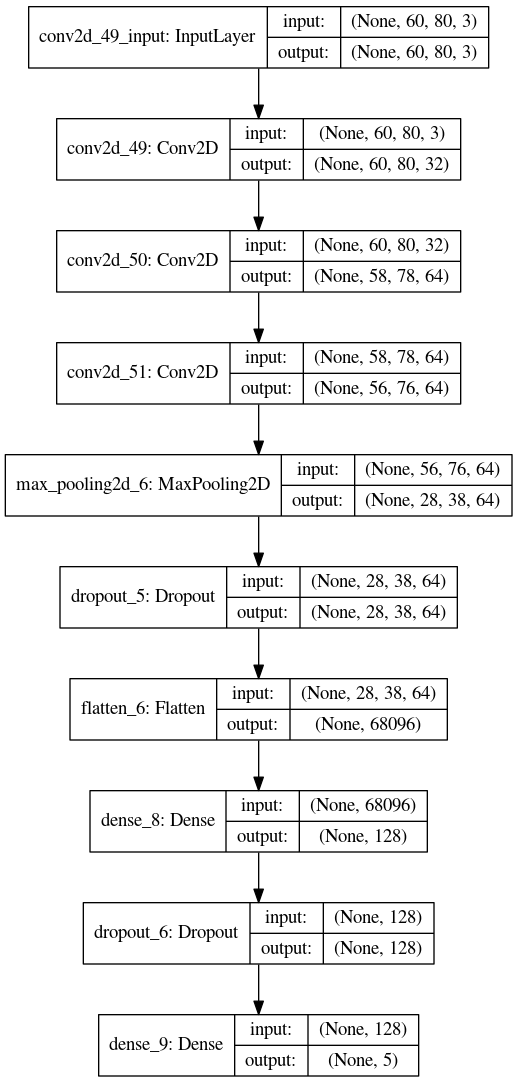

In [35]:
plot_model(mod6, to_file='mod6.png', show_shapes=True, show_layer_names=True)


In [27]:
epochs=15
mod6.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adadelta(),
                  metrics=['accuracy'])

datagen = ImageDataGenerator(
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
    rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=True,  # randomly flip images
    vertical_flip=False)  # randomly flip images

his6 = mod6.fit_generator(datagen.flow(x_train1, y_train1, batch_size=32),
                        steps_per_epoch=len(x_train1)/32, epochs=15, validation_data = (x_valid, y_valid), callbacks = [MetricsCheckpoint('logs')])

Epoch 1/15
249/248 [==============================] - 261s 1s/step - loss: 1.4284 - accuracy: 0.2829 - val_loss: 1.2689 - val_accuracy: 0.4157
Epoch 2/15
249/248 [==============================] - 265s 1s/step - loss: 1.2956 - accuracy: 0.3828 - val_loss: 1.3087 - val_accuracy: 0.3670
Epoch 3/15
249/248 [==============================] - 262s 1s/step - loss: 1.1626 - accuracy: 0.4688 - val_loss: 0.9205 - val_accuracy: 0.6054
Epoch 4/15
249/248 [==============================] - 262s 1s/step - loss: 1.0147 - accuracy: 0.5379 - val_loss: 0.8920 - val_accuracy: 0.6210
Epoch 5/15
249/248 [==============================] - 257s 1s/step - loss: 0.7995 - accuracy: 0.6372 - val_loss: 0.6178 - val_accuracy: 0.7314
Epoch 6/15
249/248 [==============================] - 258s 1s/step - loss: 0.6630 - accuracy: 0.7023 - val_loss: 0.4923 - val_accuracy: 0.7912
Epoch 7/15
249/248 [==============================] - 262s 1s/step - loss: 0.5281 - accuracy: 0.7803 - val_loss: 0.4087 - val_accuracy: 0.8183

In [69]:
input_img = Input(shape = (60, 80, 3))

tower_1 = Conv2D(64, (1,1), padding='same', activation='relu')(input_img)

tower_2 = Conv2D(64, (1,1), padding='same', activation='relu')(input_img)
tower_2 = Conv2D(64, (3,3), padding='same', activation='relu')(tower_2)



tower_3 = Conv2D(64, (1,1), padding='same', activation='relu')(input_img)
tower_3 = Conv2D(64, (3,3), padding='same', activation='relu')(tower_3)
tower_3 = Conv2D(64, (3,3), padding='same', activation='relu')(tower_3)


tower_4 = Conv2D(64, (1,1), padding='same', activation='relu')(input_img)
tower_4 = Conv2D(64, (3,3), padding='same', activation='relu')(tower_4)
tower_4 = Conv2D(64, (3,3), padding='same', activation='relu')(tower_4)
tower_4 = Conv2D(64, (3,3), padding='same', activation='relu')(tower_4)



tower_5 = MaxPooling2D((3,3), strides=(1,1), padding='same')(input_img)
tower_5 = Conv2D(64, (1,1), padding='same', activation='relu')(tower_5)

output = keras.layers.concatenate([tower_1, tower_2, tower_3, tower_4, tower_5], axis = 3)
output = MaxPooling2D((3,3), strides = (1,1), padding-'same')(output)
output = Flatten()(output)
out = Dense(5, activation='softmax')(output)

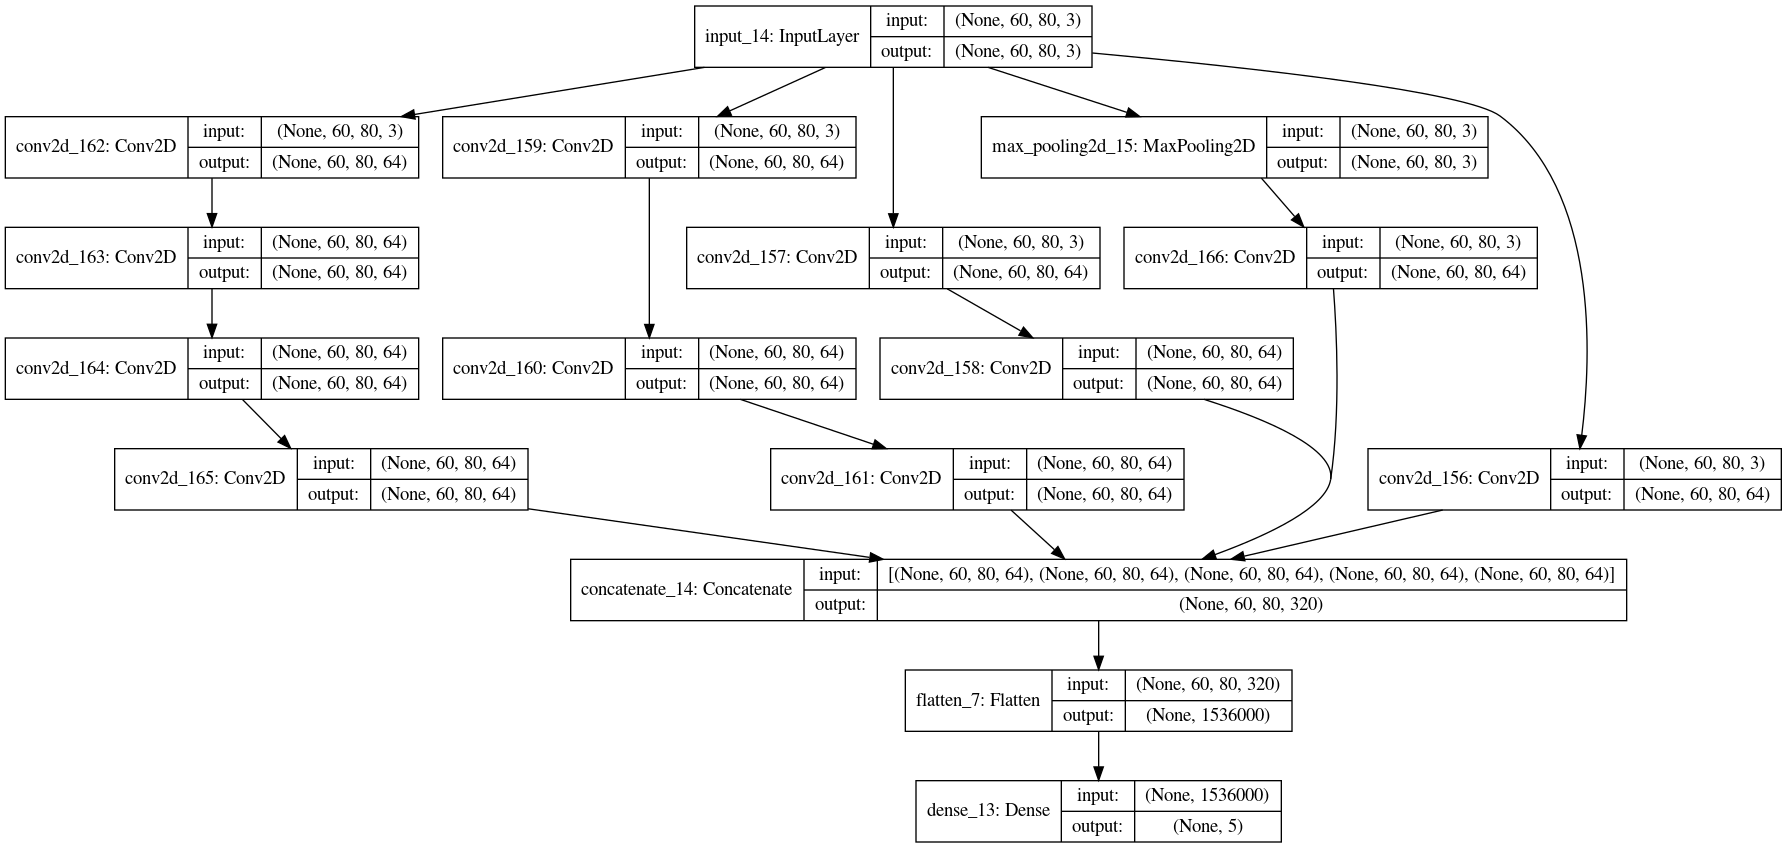

In [70]:
mod7 = Model(inputs = input_img, outputs = out)
plot_model(mod7, to_file='mod7.png', show_shapes=True, show_layer_names=True)


In [71]:
checkpoint = ModelCheckpoint(filepath='mod7.h5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
mod7.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adadelta(),
                  metrics=['accuracy'])

datagen = ImageDataGenerator(
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
    rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=True,  # randomly flip images
    vertical_flip=False)  # randomly flip images

his7 = mod7.fit_generator(datagen.flow(x_train1, y_train1, batch_size=32),
                        steps_per_epoch=len(x_train1)/32, epochs=15, validation_data = (x_valid, y_valid), callbacks = [MetricsCheckpoint('logs'), checkpoint])

Epoch 1/15
249/248 [==============================] - 255s 1s/step - loss: 8.0465 - accuracy: 0.3210 - val_loss: 1.2240 - val_accuracy: 0.3700

Epoch 00001: val_accuracy improved from -inf to 0.36998, saving model to mod7.h5
Epoch 2/15
249/248 [==============================] - 297s 1s/step - loss: 1.1181 - accuracy: 0.4974 - val_loss: 1.0893 - val_accuracy: 0.5090

Epoch 00002: val_accuracy improved from 0.36998 to 0.50904, saving model to mod7.h5
Epoch 3/15
249/248 [==============================] - 285s 1s/step - loss: 1.0091 - accuracy: 0.5659 - val_loss: 1.0130 - val_accuracy: 0.5417

Epoch 00003: val_accuracy improved from 0.50904 to 0.54167, saving model to mod7.h5
Epoch 4/15
249/248 [==============================] - 292s 1s/step - loss: 0.9247 - accuracy: 0.6107 - val_loss: 0.8989 - val_accuracy: 0.6024

Epoch 00004: val_accuracy improved from 0.54167 to 0.60241, saving model to mod7.h5
Epoch 5/15
249/248 [==============================] - 293s 1s/step - loss: 0.8802 - accurac

In [24]:
# mod2.save_weights('mod2.h5')
# mod3.save_weights('mod3.h5')
# mod4.save_weights('mod4.h5')
# mod5.save_weights('mod5.h5')
# mod6.save_weights('mod6.h5')

In [25]:
mod3.load_weights('mod3h5')
mod4.load_weights('mod4.h5')
mod5.load_weights('mod5.h5')
mod6.load_weights('mod6.h5')
mod7.load_weights('mod7.h5')


In [55]:
score2 = mod2.evaluate(X_test,y_testHot, verbose=0)
score3 = mod3.evaluate(X_test,y_testHot, verbose=0)
score4 = mod4.evaluate(X_test,y_testHot, verbose=0)
score5 = mod5.evaluate(X_test,y_testHot, verbose=0)
score6 = mod6.evaluate(X_test,y_testHot, verbose=0)

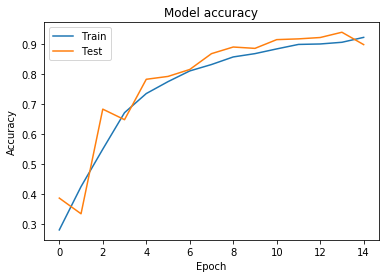

In [35]:
plt.plot(his3.history['accuracy'])
plt.plot(his3.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

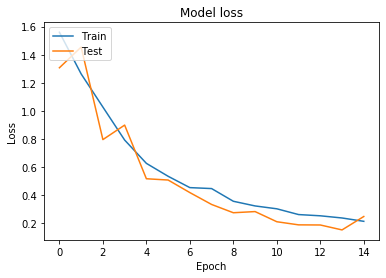

In [37]:
plt.plot(his3.history['loss'])
plt.plot(his3.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [79]:
mod2.load_weights('mod2.h5')
mod2.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adadelta(),
                  metrics=['accuracy'])


              precision    recall  f1-score   support

  NEUTROPHIL       0.54      0.81      0.65       624
  EOSINOPHIL       0.76      0.58      0.66       623
    MONOCYTE       0.87      0.62      0.73       620
  LYMPHOCYTE       0.88      0.90      0.89       620

    accuracy                           0.73      2487
   macro avg       0.76      0.73      0.73      2487
weighted avg       0.76      0.73      0.73      2487



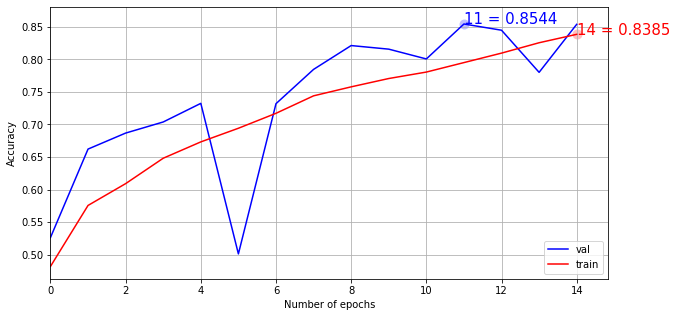

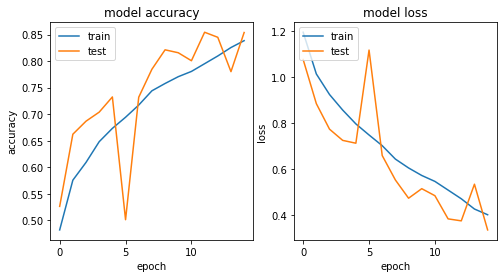

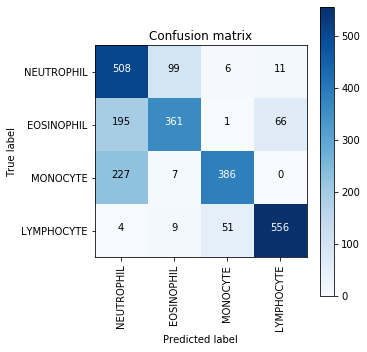

In [80]:
y_pred = mod2.predict(X_test)
map_characters = dict_characters
print('\n', sklearn.metrics.classification_report(np.where(y_testHot > 0)[1], np.argmax(y_pred, axis=1), target_names=list(map_characters.values())), sep='')    
Y_pred_classes = np.argmax(y_pred,axis=1) 
Y_true = np.argmax(y_testHot,axis=1)
#allow_pickle = True
plotKerasLearningCurve()
plt.show()  
plot_learning_curve(his2)
plt.show()
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
plot_confusion_matrix(confusion_mtx, classes = list(dict_characters.values())) 
plt.show()



              precision    recall  f1-score   support

  NEUTROPHIL       0.68      0.84      0.75       624
  EOSINOPHIL       0.84      0.68      0.75       623
    MONOCYTE       0.93      0.89      0.91       620
  LYMPHOCYTE       0.98      0.99      0.99       620

    accuracy                           0.85      2487
   macro avg       0.86      0.85      0.85      2487
weighted avg       0.86      0.85      0.85      2487



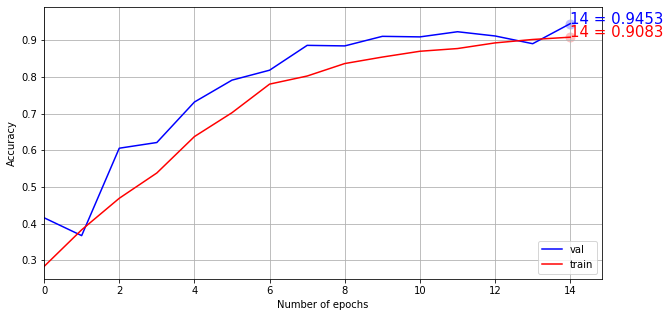

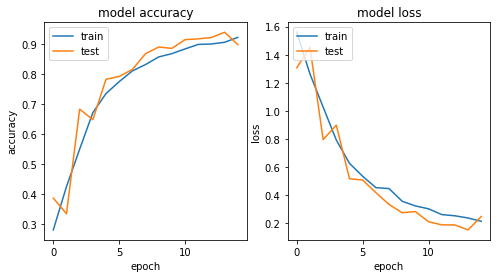

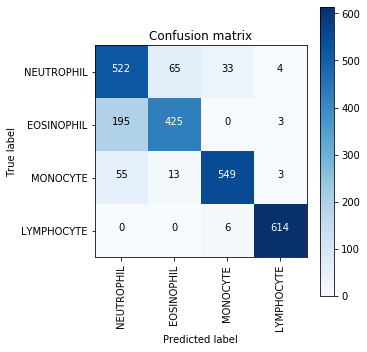

In [51]:
y_pred = mod3.predict(X_test)
map_characters = dict_characters
print('\n', sklearn.metrics.classification_report(np.where(y_testHot > 0)[1], np.argmax(y_pred, axis=1), target_names=list(map_characters.values())), sep='')    
Y_pred_classes = np.argmax(y_pred,axis=1) 
Y_true = np.argmax(y_testHot,axis=1)
#allow_pickle = True
plotKerasLearningCurve()
plt.show()  
plot_learning_curve(his3)
plt.show()
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
plot_confusion_matrix(confusion_mtx, classes = list(dict_characters.values())) 
plt.show()



              precision    recall  f1-score   support

  NEUTROPHIL       0.70      0.87      0.78       624
  EOSINOPHIL       0.84      0.85      0.84       623
    MONOCYTE       1.00      0.75      0.86       620
  LYMPHOCYTE       1.00      1.00      1.00       620

    accuracy                           0.87      2487
   macro avg       0.88      0.87      0.87      2487
weighted avg       0.88      0.87      0.87      2487



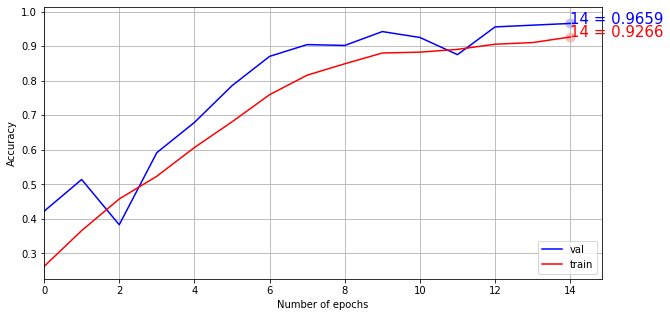

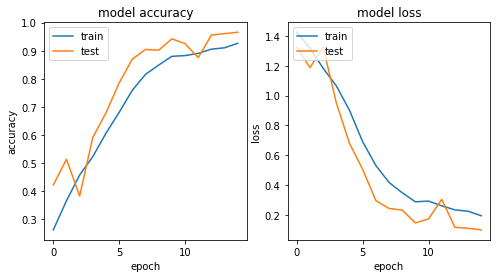

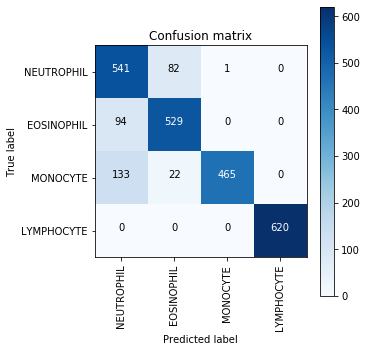

In [57]:
y_pred = mod4.predict(X_test)
map_characters = dict_characters
print('\n', sklearn.metrics.classification_report(np.where(y_testHot > 0)[1], np.argmax(y_pred, axis=1), target_names=list(map_characters.values())), sep='')    
Y_pred_classes = np.argmax(y_pred,axis=1) 
Y_true = np.argmax(y_testHot,axis=1)
#allow_pickle = True
plotKerasLearningCurve()
plt.show()  
plot_learning_curve(his4)
plt.show()
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
plot_confusion_matrix(confusion_mtx, classes = list(dict_characters.values())) 
plt.show()



              precision    recall  f1-score   support

  NEUTROPHIL       0.47      0.74      0.58       624
  EOSINOPHIL       0.67      0.22      0.33       623
    MONOCYTE       0.90      0.98      0.94       620
  LYMPHOCYTE       0.87      0.89      0.88       620

    accuracy                           0.71      2487
   macro avg       0.73      0.71      0.68      2487
weighted avg       0.73      0.71      0.68      2487



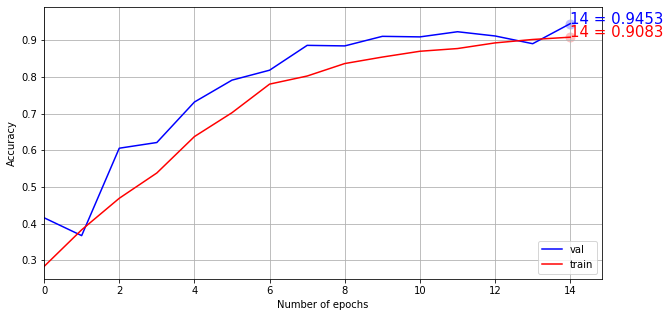

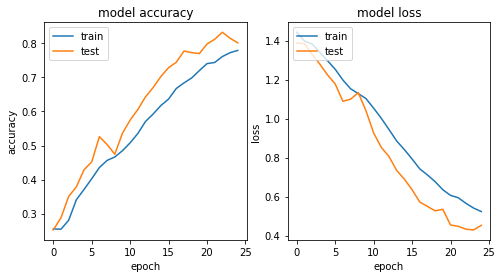

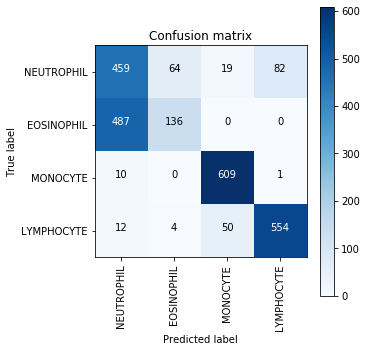

In [53]:
y_pred = mod5.predict(X_test)
map_characters = dict_characters
print('\n', sklearn.metrics.classification_report(np.where(y_testHot > 0)[1], np.argmax(y_pred, axis=1), target_names=list(map_characters.values())), sep='')    
Y_pred_classes = np.argmax(y_pred,axis=1) 
Y_true = np.argmax(y_testHot,axis=1)
#allow_pickle = True
plotKerasLearningCurve()
plt.show()  
plot_learning_curve(his5)
plt.show()
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
plot_confusion_matrix(confusion_mtx, classes = list(dict_characters.values())) 
plt.show()



              precision    recall  f1-score   support

  NEUTROPHIL       0.74      0.81      0.77       624
  EOSINOPHIL       0.75      0.87      0.81       623
    MONOCYTE       1.00      0.75      0.86       620
  LYMPHOCYTE       1.00      1.00      1.00       620

    accuracy                           0.86      2487
   macro avg       0.87      0.86      0.86      2487
weighted avg       0.87      0.86      0.86      2487



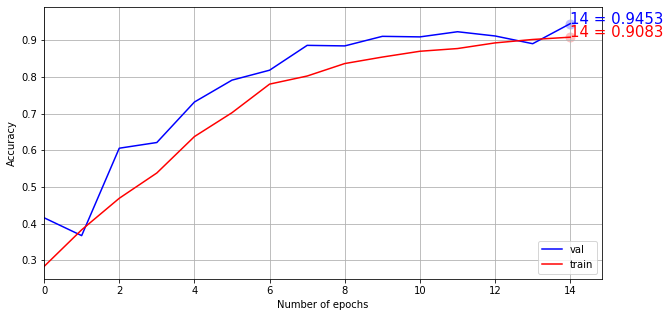

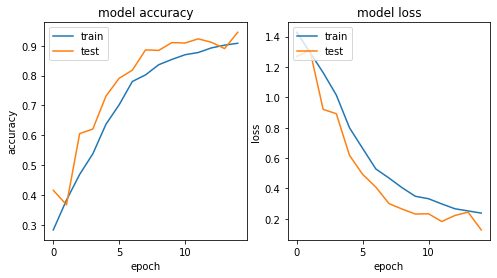

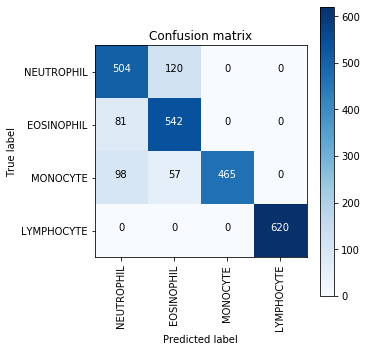

In [54]:
y_pred = mod6.predict(X_test)
map_characters = dict_characters
print('\n', sklearn.metrics.classification_report(np.where(y_testHot > 0)[1], np.argmax(y_pred, axis=1), target_names=list(map_characters.values())), sep='')    
Y_pred_classes = np.argmax(y_pred,axis=1) 
Y_true = np.argmax(y_testHot,axis=1)
#allow_pickle = True
plotKerasLearningCurve()
plt.show()  
plot_learning_curve(his6)
plt.show()
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
plot_confusion_matrix(confusion_mtx, classes = list(dict_characters.values())) 
plt.show()


In [45]:
mod4.load_weights('mod4.h5')

mod4.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adadelta(),
                  metrics=['accuracy'])

In [76]:
mod7.load_weights('mod7.h5')
mod7.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adadelta(),
                  metrics=['accuracy'])


              precision    recall  f1-score   support

  NEUTROPHIL       0.45      0.74      0.56       624
  EOSINOPHIL       0.66      0.39      0.49       623
    MONOCYTE       0.94      0.75      0.84       620
  LYMPHOCYTE       0.87      0.84      0.85       620

    accuracy                           0.68      2487
   macro avg       0.73      0.68      0.69      2487
weighted avg       0.73      0.68      0.68      2487



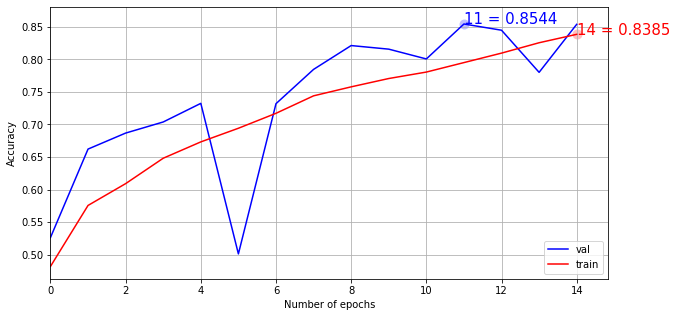

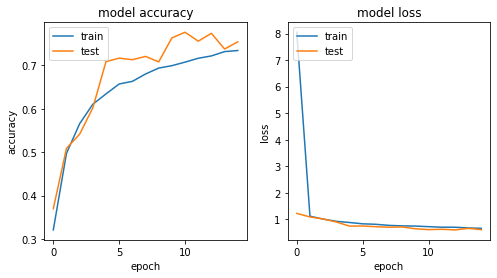

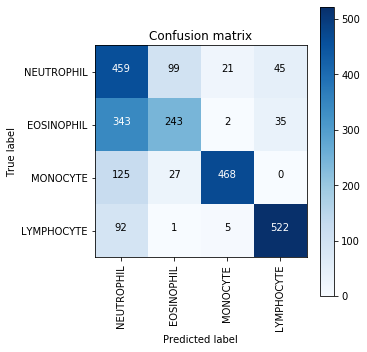

In [78]:
y_pred = mod7.predict(X_test)
map_characters = dict_characters
print('\n', sklearn.metrics.classification_report(np.where(y_testHot > 0)[1], np.argmax(y_pred, axis=1), target_names=list(map_characters.values())), sep='')    
Y_pred_classes = np.argmax(y_pred,axis=1) 
Y_true = np.argmax(y_testHot,axis=1)
#allow_pickle = True
plotKerasLearningCurve()
plt.show()  
plot_learning_curve(his7)
plt.show()
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
plot_confusion_matrix(confusion_mtx, classes = list(dict_characters.values())) 
plt.show()


In [60]:
score_simple = mod4.evaluate(X_test_simple,y_stestHot, verbose=0)


In [61]:
score_simple

[0.25941003460279655, 0.8591549396514893]